# GC model in Python
## Solving Gouy-Chapman (GC) numerically from scratch

In today's exercise, we will seek to solve the Gouy-Chapman (GC) Boundary Value Problem (BVP) numerically:

$$
\text{GCS (1D):} 
\begin{cases} 
\frac{\text{d}^{2}\phi}{\text{d}x^{2}} = \frac{F c_{b}}{\epsilon_{s}}\sinh(\frac{F\phi}{RT}), & X \in \left(0, L_{\text{max}}\right) \\
\phi(x = L_{\text{min}}) = \phi_{0}, & X = L_{\text{min}} \tag{1} \\
\lim_{x \to L_{\text{max}}} \phi(x = L_{\text{max}}) = 0, & X \to L_{\text{max}}
\end{cases}
$$

where F is the Faraday constant, $\approx 9.649\cdot 10^{4} \text{ C}\cdot\text{mol}^{-1}$, $\epsilon_{\text{S}}$ is the relative permittivity (old: dielectric constant) of the solvent with respect to electric permittivity of a vacuum, $\epsilon_{\text{S}}\approx 78.5$ (for pure water), $c_{b}$ is the bulk concentration (Molar, M or millimolar, mM), $\phi$ is the electric potential (Volt, V), $x$ is the distance from the electrode (nm). $L_{\text{min}}$ is the position of the electrode surface (nm). $L_{max}$ is the maximum distance from the electrode surface (nm). $\phi_{0}$ is the electrode potential relative to the potential of zero charge: 
$$
\begin{align}
    \phi_{0} = \phi_{M} - \phi_{\text{pzc}} \tag{2}
\end{align}
$$

- Compare the $\phi_{0}$ in Gouy-Chapman (GC) with the Gouy-Chapman-Stern model. What is different? If you use the slides (2025), you may adopt the following notation: $\phi_{i} = E_{i}$.
<p><p>
    
We will adopt the Newton-Raphson method and benchmark (show that our model works) using the analytical solution to the problem with boundary conditions for $L_{\text{min}} = 0$ and $L_{\text{max}} \to \infty$:

$$
\begin{align}
\phi = 2\, \ln\left(\frac{\sqrt{\exp\left(\phi_{0}\right)} - \tanh\left(-x \sqrt{\frac{2 F^{2}c_{b} }{RT\epsilon_{s}}}\right) }{1 - \sqrt{\exp\left(\phi_{0}\right)}\tanh\left(-x \sqrt{\frac{2 F^{2}c_{b} }{RT\epsilon_{s}}}\right) }\right) \tag{3}
\end{align}
$$

where $R$ is the gas constant, $\approx 8.3145 \text{ J}\cdot \text{mol}^{-1}\cdot\text{K}^{-1}$, and $T$ is the temperature (Kelvin, K).

### Setup parameters

The first step, and probably the easiest, is to define the parameters of the model. This can be done in a simple script. But let's define it using classes. This way, we can also use getters (get the values) and setters (restrictions imposed using physical intuition). Example: We get the temperature. And we know that the temperature, in Kelvin, can only take positive real numbers. If at any point we impose a negative value temeprature, we immediatly raise an error.

In [30]:
class Params:
    
    # Valid keys
    valid_keys = ['T', 'epsilon_s', 'concentration_mM', 'phi_M', 'phi_pzc', 'N', 'L_min', 'L_max']
    
    r"""
    Parameters for the Gouy-Chapman (GC) model, including fundamental physical constants.

    Fundamental constants (fixed for all simulations):
    ---------------------------------------------------
    - kB : float
        Boltzmann constant \((k_B = 1.381 \times 10^{-23} \ \text{J/K})\).
    - q : float
        Elementary charge \((q = 1.602 \times 10^{-19} \ \text{C})\).
    - NA : float
        Avogadro's number \((N_A = 6.02214076 \times 10^{23} \ \text{mol}^{-1})\).
    - R : float
        Gas constant \((R = 8.3145 \ \text{J/mol·K})\).
    - F : float
        Faraday constant \((F = 9.649 \times 10^4 \ \text{C/mol})\).
    - epsilon0 : float
        Vacuum permittivity \((\epsilon_0 = 8.854 \times 10^{-12} \ \text{F/m})\).

    Simulation parameters (user-defined):
    -------------------------------------
    - T : float
        Temperature in Kelvin.
    - epsilon_s : float
        Relative permittivity of the medium.
    - concentration_mM : float
        Bulk electrolyte concentration in millimolar (mM).
    - phi_M : float
        Electrode potential (Volt).
    - phi_pzc : float
        Point of zero charge with respect to the electrode potential (Volt).
    - N : int
        Number of grid points in the spatial domain.
    - L_min : float
        Minimum spatial domain length in meters.
    - L_max : float
        Maximum spatial domain length in meters.

    Derived attributes:
    --------------------
    - c_b_mol : float
        Bulk concentration in millimolar per meter cubed (mmol/m³).
    - n_b : float
        Number density of particles (1/cm³).
    """
    
    def __init__(self, T=298.15, epsilon_s=78.5, concentration_mM=100.0, phi_M = 1.0,
                        phi_pzc=0.0, N=2**6, L_min=0.0, L_max = 5e-9):
        """
        Initialize simulation parameters for the GCS model.

        Sets physical constants, simulation domain bounds, and computes
        derived properties such as molar concentration and particle density.
        """
        
        # Fundamental constants
        self.kB = 1.381e-23      # Boltzmann constant [J/K]
        self.q = 1.602e-19       # Elementary charge [C]
        self.NA = 6.02214076e23  # Avogadro's number [1/mol]
        self.R = 8.3145          # Gas constant [J/mol·K]
        self.F = 9.649e4         # Faraday constant [C/mol]
        self.epsilon0 = 8.854e-12  # Vacuum permittivity [F/m]

        # Parameters
        self.T = T
        self.epsilon_s = epsilon_s
        self.c_b_mol = concentration_mM
        self.phi_M = phi_M
        self.phi_pzc = phi_pzc
        self.N = N
        
        # Retrieved parameters
        self.set_domain_bounds(L_min, L_max)
        self.n_b = self.calculate_particle_density(self.c_b_mol)
    
    @property
    def T(self):
        """Return the temperature in Kelvin."""
        return self._T

    @T.setter
    def T(self, value):
        """
        Set the temperature (Kelvin).

        Parameters
        ----------
        value : float
            The temperature in Kelvin. Must be greater than one.

        Raises
        ------
        ValueError
            If the temperature is less than or equal to zero.
        """
        if value <= 0:
            raise ValueError("Temperature must be positive.")
        self._T = value

    @property
    def epsilon_s(self):
        """Return the relative permittivity of the medium."""
        return self._epsilon_s

    @epsilon_s.setter
    def epsilon_s(self, value):
        """
        Set the relative permittivity.

        Parameters
        ----------
        value : float
            The relative permittivity of the medium. Must be greater than zero.

        Raises
        ------
        ValueError
            If the relative permittivity is less than one.
        """
        if value < 1:
            raise ValueError("Permittivity must be greater than 1.")
        self._epsilon_s = value

    @property
    def concentration_mM(self):
        """Return the bulk concentration in millimolar."""
        return self._concentration_mM

    @concentration_mM.setter
    def concentration_mM(self, value):
        """
        Set the bulk concentration in millimolar.

        Parameters
        ----------
        value : float
            The concentration in millimolar (mM). Must be greater than zero.

        Raises
        ------
        ValueError
            If the concentration is less than or equal to zero.
        """
        if value <= 0:
            raise ValueError("Concentration must be positive.")
        self._concentration_mM = value

    @property
    def N(self):
        """Return the number of grid points in the spatial domain."""
        return self._N

    @N.setter
    def N(self, value):
        """
        Set the number of grid points.

        Parameters
        ----------
        value : int
            The number of grid points. Must be a positive integer.

        Raises
        ------
        ValueError
            If the number of grid points is not a positive integer.
        """
        if not isinstance(value, int) or value <= 0:
            raise ValueError("Number of grid points must be a positive integer.")
        self._N = value
    
        
    @property
    def L_min(self):
        """Return the minimum length of the domain in meters."""
        return self._L_min

    @property
    def L_max(self):
        """Return the maximum length of the domain in meters."""
        return self._L_max
    
    def set_domain_bounds(self, L_min, L_max):
        """
        Set the spatial domain boundaries for the simulation.

        This method assigns the minimum and maximum lengths of the spatial domain
        and checks that the values are physically valid. It ensures that `L_min` is
        strictly less than `L_max` to avoid degenerate or reversed domains.

        Parameters
        ----------
        L_min : float
            The minimum boundary of the spatial domain, in meters.
        L_max : float
            The maximum boundary of the spatial domain, in meters.

        Raises
        ------
        ValueError
            If `L_min` is greater than or equal to `L_max`.
        """
        if L_min >= L_max:
            raise ValueError("L_min must be less than L_max.")
        self._L_min = L_min
        self._L_max = L_max

    def calculate_particle_density(self, concentration_molar):
        """Calculates number density of particles (1/cm³)."""
        return concentration_molar * self.NA

### Parameter Class check
If we do not check if what we are doing works, then we cannot really blame anyone but ourselves, if the code does not work down the line. Let us check if this satistifies our expectations. For this reason, I want you to answer the following questions using the code snippet below:

- What would you do in order to fix the code snippet? 
- How would you change the number of grid points to 256? 
- What would you do, if you **only** wanted default values?

In [31]:
# Check if the parameters are allowed

#----- YOUR INPUT -----#
T = -298

L_minnn = 0

L_max = -5e-9

# ?

#----- YOUR INPUT -----#

In [32]:
# Get all valid keys based on the params class
valid_keys = Params.valid_keys  # Defined inside the class
inputs = {key: globals()[key] for key in valid_keys if key in globals()}

# Employ try and except to show succesfull values
# And tell user if any errors are arised.
try:
    #overwrite 
    params = Params(**inputs)
    
    #compare with default values
    default = Params()
    
    print("Params object created successfully.")
    print("Overwritten parameters:")
    for key in valid_keys:
        val = getattr(params, key)
        if key in inputs:
            print(f"  {key} = {val}  (user-defined)")
        else:
            print(f"  {key} = {val}  (default)")
except ValueError as e:
    print(f"Caught an error: {e}")
except TypeError as e:
    print("TypeError: you misspelled a parameter name")
    print("", e)

Caught an error: Temperature must be positive.


# From real world to numerical
The Newton<span>&ndash;</span>Raphson method is a method used to solve nonlinear differential equations. But in order to employ it, the differential equation in question, eq. (1), ought to be discretized.

## Discretization
Everything in the physical world is either continous and smooth, discrete or somewhere inbetween. Unfortunately, computers only understadnd the discretized world. Therefore, if we wish to numerically/ computationally solve GCS (or any differential equation for that matter), we must employ a method, which rewrites any $\frac{d^{2} \phi}{\text{d}x^{2} }$ terms in a way that the computer will understand. This is called discretization. For today's exercises, we employ a Second Order Central Difference discretization. Let $N$ be the amount of grid points and $i\in {0,1,2, \cdots, N -1}$ and  assume that our $x$ is uniformly distributed: $h = x_{i+1} - x_{i}$ for $0\geq i \geq N - 2$, then the difference is found by the following expression: $\frac{d^{2} \phi}{\text{d}x^{2} } \approx \frac{\phi\left(x_{i}+h\right) - 2\phi\left(x_{i}\right) + \phi\left(x_{i} - h\right) }{h^{2} }$. In this way, eq. (1) now becomes:
$$
    \frac{\phi\left(x_{i}+h\right) - 2\phi\left(x_{i}\right) + \phi\left(x_{i} - h\right) }{h^{2} } = \frac{F c_{b}}{\epsilon_{s}}\sinh(\phi(x_{i})) \tag{4}
$$
though, because we want to list the $\phi$ values as list anyway, we may instead impose the following way of counting: $\cdots, \phi^{(i-1)} = \phi\left(x_{i} - h\right),\phi^{(i)} = \phi\left(x_{i}\right), \phi^{(i+1)} = \phi\left(x_{i} + h\right), \cdots$. This way, we can define an important property, namely the residual:
$$
    F_{i} = F\left(\phi^{(i)}\right) = \frac{\phi^{(i-1)} - 2\phi^{(i)} + \phi^{(i+1)}  }{h^{2} } - \frac{F c_{b}}{\epsilon_{s}} \sinh\left(\phi^{(i)}\right) \tag{5}
$$
Which is $just$ the Left-Hand-Side (internal term) substracted by the Right-Hand-Side (external/ source term). If $F_{i} \approx 0$ for all $i$, we have solved the problem. We need to calculate a value that encapsulates the overall assessment of the error being close to $0$. A good choice is the euclidean norm:
$$
    ||\mathbf{F}||_{2} = \sqrt{F_{1}^{2} + F_{2}^{2} + \cdots + F_{N}^{2}} \tag{6}
$$
If this norm is smaller than a preset tolerance value (in this exercise we choose $10^{-10}$): $||\mathbf{F}||_{2} < \varepsilon_{\text{error}}$, we say that our simulation has reached convergence and plot the $\phi$ or use it for post-processing. Now, that we have a goal, we just need a means of procedure. This is where Newton-Raphson comes in. 


## Newton<span>&ndash;</span>Raphson method
In order to reach convergence, we need a procedure which changes the $\phi$-values for better or worse. The Newton-Raphson procedure proposes the following method:
$$
    \mathbf{J}\Delta\phi = \mathbf{F} \tag{6}
$$
which you may recognize as a linear system. $J$ is the Jacobian defined by:
$$
    J_{ij} = \frac{\text{d} F_{i}}{\text{d} \phi^{(j)}} \tag{7}
$$
and just like before, differential quotients cannot be true in numerical/ computational studies. Again, we impose a second order central difference method, this time applied to a first order derivative:
$$
    J_{ij} \approx \frac{F_{i}\left(\phi_{1}, \phi_{2}, \cdots, \phi_{j} + \epsilon, \cdots, \phi_{N}\right) - F_{i}\left(\phi_{1}, \phi_{2}, \cdots, \phi_{j} - \epsilon, \cdots, \phi_{N}\right)}{2\epsilon} \tag{8}
$$
where $\epsilon$ serves the purpose as $h$ before. Finally, we can solve subtitute into eq. (6) and solve for $\Delta \phi$. If we keep doing this, updating $\mathbf{F}$ at every iteration and checking for convergence, we should have final method. We just need to update the solution using the prior iteration step $\phi^{(k)}$:
$$
\mathbf{\phi}^{(k+1)} = \mathbf{\phi}^{(k)} + \Delta \mathbf{\phi}^{(k)} \tag{9}
$$
One last question arises. How do solve the linear system provided by eq. (6)? This is beyond the scope of this course, but we employ [LU decomposition](https://en.wikipedia.org/wiki/LU_decomposition), which the curious student is welcome to look up.

## The beginning
For the solver to work, we need to start somewhere. In other words, we need to specify $\phi^{(0)}$. This is called our initial guess:
$$
\begin{align}
    \phi^{(0)} = \phi_{\text{initial guess}}
\end{align}
$$
The closer the initial guess is to the real solution, the quicker the convergence. Run the plot below to assess which initial guess would we best

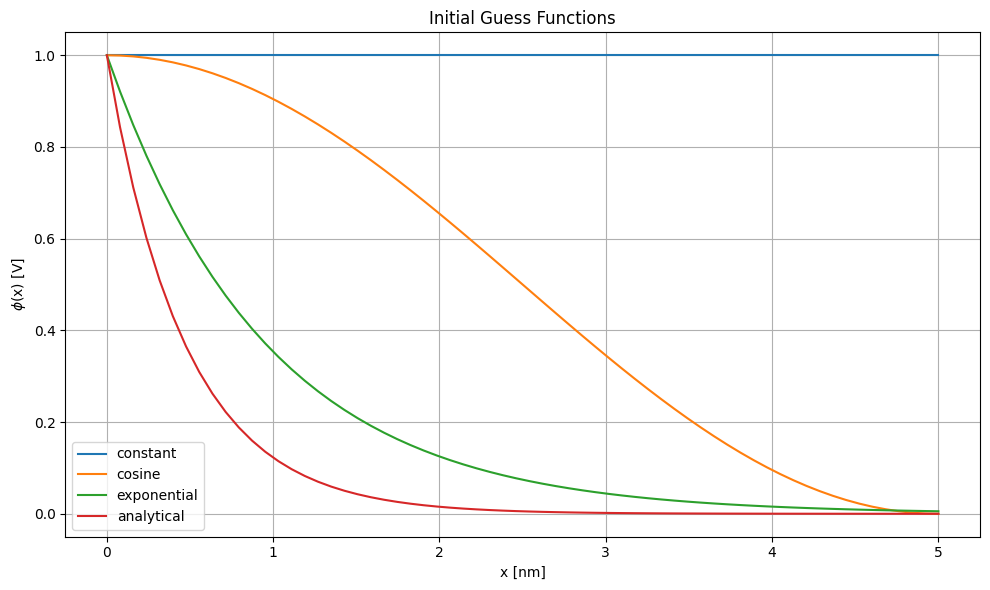

In [33]:
from math import exp, cos, sqrt, tanh, log, pi
import matplotlib.pyplot as plt

class InitialGuess:
    r"""
    Generate an initial guess for $\phi(x)$ over the spatial grid using one of the following modes:
    
    Modes
    -----
    - 'constant'   : $\phi(x) = \phi_{0}$
        A continuous constant easy-to-implement function
        
    - 'cosine'     : $\phi(x) = \frac{\phi_0}{2} \cdot \cos\left( -\pi \cdot \frac{x - L_{\text{min}}}{L_{\text{max}} - L_{\text{min}}} + 1 \right)$
        A smooth periodic cosine wave
    
    - 'exponential': $\phi(x) = \phi_{0} · exp\left(−\left(x - L_{\text{min}} \right)\right)$
        A smooth exponentially decaying profile
    
    - 'analytical' : $\phi(x) = 2 \ln\left( \frac{\sqrt{\exp\left(\right)} - \tanh\left(-x \sqrt{\frac{2 F^{2}c_{b} }{RT \epsilon_{S}}}\right) }{1 - \sqrt{\exp\left(\phi_{0}\right)}\tanh\left(-x \sqrt{\frac{2F^{2}c_{b} }{RT\epsilon_{S}}}\right) } \right) $ 
        Exact GC solution for $\phi(x)$ on infinite domain
    """
    def __init__(self, params, x):
        self.params = params
        self.x = x
        self.N = self.params.N
        self.L_min = self.params.L_min
        self.L_max = self.params.L_max
        self.phi0 = params.phi_M - params.phi_pzc

    def generate(self, mode: str = "constant"):
        match mode:
            case "constant":
                return [self.phi0 for _ in self.x]

            case "cosine":
                return [self.phi0 / 2 * (cos(-pi * (xi - self.L_min) / (self.L_max - self.L_min)) + 1) for xi in self.x]

            case "exponential":
                F = self.params.F
                R = self.params.R
                T = self.params.T
                c_b = self.params.c_b_mol
                eps = self.params.epsilon_s * self.params.epsilon0
                lambda_D = sqrt(eps * R * T / (2 * F**2 * c_b))
                return [self.phi0 * exp(-(xi - self.L_min) / lambda_D) for xi in self.x]

            case "analytical":
                F = self.params.F
                R = self.params.R
                T = self.params.T
                c_b = self.params.c_b_mol
                eps = self.params.epsilon_s * self.params.epsilon0
                sqrt_exp_phi0 = sqrt(exp(self.phi0))
                kappa = sqrt(2 * F**2 * c_b / (R * T * eps))

                return [
                    2 * log(
                        (sqrt_exp_phi0 - tanh(-(xi - self.L_min) * kappa)) /
                        (1 - sqrt_exp_phi0 * tanh(-(xi - self.L_min) * kappa))
                    ) for xi in self.x
                ]

            case _:
                raise ValueError(f"Unknown mode '{mode}'. Choose from 'constant', 'cosine', 'exponential', 'analytical'.")

# === Example plot ===
if __name__ == "__main__":
    params = Params()
    h = (params.L_max - params.L_min) / (params.N - 1)
    x = [params.L_min + i * h for i in range(params.N)]
    guesser = InitialGuess(params, x)

    modes = ["constant", "cosine", "exponential", "analytical"]
    plt.figure(figsize=(10, 6))
    for mode in modes:
        phi = guesser.generate(mode=mode)
        x_nm = [xi * 1e9 for xi in x]
        plt.plot(x_nm, phi, label=mode)


    plt.xlabel("x [nm]")
    plt.ylabel(r"$\phi$(x) [V]")
    plt.title("Initial Guess Functions")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [55]:
from math import exp

class Residual:
    """
    Class to compute the residual F(phi) for the GC model.

    Parameters
    ----------
    params : Params
        Simulation parameters containing constants and grid information.

    Attributes
    ----------
    params : Params
        Stored parameters object for easy access.
    h : float
        Grid spacing.
    prefactor : float
        Precomputed prefactor (F * c_b) / (epsilon_r) for residual.
    """
    def __init__(self, params, boundary_value=1.0, mode = "dimensionless"):
        self.params = params
        self.h = (params.L_max - params.L_min) / (params.N - 1)
        self.boundary_value = boundary_value  # can be phi0 or U0
        self.mode = mode


    def compute_residual(self, phi):
        r"""
        Compute the residual vector F(phi or U), for either dimensional or dimensionless GC model.

        If `mode == "dimensional"`:
            d²φ/dx² = (F c_b / ε) * sinh(Fφ / RT)
        If `mode == "dimensionless"`:
            d²U/dX² = sinh(U)

        Parameters
        ----------
        phi : list of floats
            List of potential values at the grid points (either φ or U).

        Returns
        -------
        F_residual : list of floats
            Residual vector.
        """
        N = self.params.N
        F_residual = [0.0 for _ in range(N)]

        for i in range(1, N - 1):
            if self.mode == "dimensional":
                F = self.params.F
                R = self.params.R
                T = self.params.T
                eps_0 = 8.854187817e-12
                eps = self.params.epsilon_s * eps_0
                c_b = self.params.c_b_mol
                rhs = (F * c_b / eps) * self.sinh(F * phi[i] / (R * T))
                laplace = (phi[i-1] - 2 * phi[i] + phi[i+1]) / (self.h**2)
            else:
                rhs = self.sinh(phi[i])
                laplace = phi[i-1] - 2 * phi[i] + phi[i+1]

            F_residual[i] = laplace - rhs

        # Boundary conditions
        F_residual[0] = phi[0] - self.boundary_value
        F_residual[-1] = phi[-1] - (self.params.phi_M - self.params.phi_pzc)

        return F_residual


    def sinh(self, x):
        r"""
        Compute sinh(x).

        The hyperbolic sine function is defined as:
        
        $$
        \sinh(x) = \frac{e^{x} - e^{-x}}{2}
        $$

        Parameters
        ----------
        x : float

        Returns
        -------
        sinh(x) : float
        """
        return (exp(x) - exp(-x)) / 2


In [56]:
class Jacobian:
    def __init__(self, residual_calculator, epsilon=1e-4):
        self.residual_calculator = residual_calculator
        self.params = residual_calculator.params
        self.epsilon = epsilon

    def compute_jacobian(self, phi):
        N = self.params.N
        J_matrix = [[0.0 for _ in range(N)] for _ in range(N)]

        for j in range(1, N - 1):
            phi_forward = phi[:]
            phi_backward = phi[:]
            phi_forward[j] += self.epsilon
            phi_backward[j] -= self.epsilon

            F_forward = self.residual_calculator.compute_residual(phi_forward)
            F_backward = self.residual_calculator.compute_residual(phi_backward)

            for i in range(1, N - 1):
                J_matrix[i][j] = (F_forward[i] - F_backward[i]) / (2 * self.epsilon)

        J_matrix[0] = [0.0] * N
        J_matrix[0][0] = 1.0

        J_matrix[-1] = [0.0] * N
        J_matrix[-1][-1] = 1.0

        return J_matrix


In [57]:
class LUSolver:
    def __init__(self, A):
        self.L, self.U, self.P = self.lu_decomposition(A)

    def lu_decomposition(self, A):
        n = len(A)
        L = [[0.0]*n for _ in range(n)]
        U = [row[:] for row in A]  # deep copy
        P = list(range(n))  # permutation vector

        for i in range(n):
            # Partial pivoting
            max_row = max(range(i, n), key=lambda r: abs(U[r][i]))
            if abs(U[max_row][i]) < 1e-14:
                U[max_row][i] = 1e-14  # Regularization: prevent division by zero


            # Swap rows in U and permutation vector
            U[i], U[max_row] = U[max_row], U[i]
            P[i], P[max_row] = P[max_row], P[i]

            # Swap rows in L (only first i entries matter)
            for k in range(i):
                L[i][k], L[max_row][k] = L[max_row][k], L[i][k]

            L[i][i] = 1.0
            for j in range(i + 1, n):
                factor = U[j][i] / U[i][i]
                L[j][i] = factor
                for k in range(i, n):
                    U[j][k] -= factor * U[i][k]

        return L, U, P

    def solve(self, b):
        # Apply row permutation to b
        Pb = [b[i] for i in self.P]
        n = len(b)

        # Forward substitution
        y = [0.0] * n
        for i in range(n):
            y[i] = Pb[i] - sum(self.L[i][j] * y[j] for j in range(i))

        # Backward substitution
        x = [0.0] * n
        for i in reversed(range(n)):
            x[i] = (y[i] - sum(self.U[i][j] * x[j] for j in range(i + 1, n))) / self.U[i][i]

        return x


In [58]:
class Solver:
    def __init__(self, params, phi0_guess, tol=1e-8, max_iter=50, plotter=None, boundary_value=0.0, mode="dimensionless"):
        self.params = params
        self.tol = tol
        self.max_iter = max_iter
        self.phi = phi0_guess[:]
        self.plotter = plotter  # expects a Plotting object or callable
        self.boundary_value = boundary_value
        self.mode = mode
        
    def solve(self):
        residual_calc = Residual(self.params, boundary_value=self.boundary_value, mode=self.mode)
        jacobian_calc = Jacobian(residual_calc)

        for iteration in range(self.max_iter):
            F = residual_calc.compute_residual(self.phi)
            norm_F = max(abs(f) for f in F)

            print(f"Iteration {iteration}: Residual norm = {norm_F:.2e}")

            if norm_F < self.tol:
                print(f"Converged in {iteration} iterations with residual {norm_F:.2e}")
                return

            J = jacobian_calc.compute_jacobian(self.phi)
            lu_solver = LUSolver(J)
            delta_phi = lu_solver.solve([-f for f in F])  # Newton step

            Jdelta = [sum(J[i][j] * delta_phi[j] for j in range(len(J))) for i in range(len(J))]
            residual_check = [Jdelta[i] + F[i] for i in range(len(F))]
            check_norm = max(abs(r) for r in residual_check)

            step_norm = max(abs(d) for d in delta_phi)

            max_step = 5.0
            if step_norm > max_step:
                scale = max_step / step_norm
                delta_phi = [d * scale for d in delta_phi]

            alpha = 1.0
            old_phi = self.phi[:]
            while alpha > 1e-6:
                trial_phi = [phi_i + alpha * dphi_i for phi_i, dphi_i in zip(old_phi, delta_phi)]
                trial_phi = [max(min(p, 30), -30) for p in trial_phi]
                trial_residual = residual_calc.compute_residual(trial_phi)
                trial_norm = max(abs(f) for f in trial_residual)

                if trial_norm <= (1 - 1e-4 * alpha) * norm_F:
                    self.phi = trial_phi
                    break
                alpha *= 0.5
            else:
                fallback_phi = [phi_i + 1e-3 * dphi_i for phi_i, dphi_i in zip(old_phi, delta_phi)]
                fallback_phi = [max(min(p, 30), -30) for p in fallback_phi]
                fallback_residual = residual_calc.compute_residual(fallback_phi)
                fallback_norm = max(abs(f) for f in fallback_residual)
                print(f"    Fallback residual = {fallback_norm:.2e}")

                if fallback_norm < norm_F:
                    self.phi = fallback_phi
                    print("    Fallback step accepted.")
                else:
                    print("    Fallback step worsened residual — reverting")
                    self.phi = old_phi

        print("Warning: Solver did not converge.")

    def get_phi(self):
        return self.phi


# Post-processing &ndash; The values/ plots we actually want to see
Just because we solve for the electric potential, $\phi$, doesn't it mean that this value is what we are interested in. It is more often than not that we want to plot some of the following:
- Differential double-layer capacitance, $C_{\text{dl}}$
- Surface charge density, $\sigma$
- Concentration profiles for anions, $c_{-}$, and cations, $c_{+}$.
<br>
$\qquad\qquad\qquad\vdots$
<br>
This process of calculating properties after after our main process (the solving part) is called post-processing or post-treatment.
### Calculating the properties
In the case of the three examples above, these can calculated using:
$$
\begin{align}
    c_{-} &= c_{b}\, \exp\left(-\frac{F \phi}{RT}\right), \\
    c_{+} &= c_{b}\, \exp\left(+\frac{F \phi}{RT}\right), \\
    \sigma &= \epsilon_{S}\frac{\text{d} \phi}{\text{d}x }\big{|}_{x = 0^{+}} \\
    C_{\text{dl}} &= \frac{\text{d} \sigma}{\text{d} \phi}
\end{align}
$$
Please note that all of these expressions have analytical solution, since $\phi$ had an analytical solution.
<br>
For $\sigma$, we again run into trouble when differentiating, since the computer does not understand this. To this end, employ a first order forward difference:
$$
    \sigma \approx \epsilon_{S}\frac{\phi^{1} - \phi^{0} }{h}
$$
Please note that the first number for the electric potential should correspond to the boundary condition at the electrode surface: $\phi^{0} = \phi_{0} = \phi_{M} - \phi_{\text{pzc}}$. If we run our simulation multiple times with different boundary conditions, we will get a list of surface charge densities: $\sigma = \left[\sigma^{1}, \sigma^{2}, \cdots, \sigma^{N}\right]$. Changing parameters to run the simulation multiple times is called a parametric sweep.
<br>
For $C_{\text{dl}}$, we again employ a second order central difference:
$$
\begin{align}
    C_{\text{dl}}^{i} \approx \frac{ \sigma^{i-1}-2\sigma^{i} + \sigma^{i+1} }{h^{2} }
\end{align}
$$
### Plotting and Presenting
After calculating the last values, we just need to plot our data. The most important part of the plot is to give ourselves and the reader a qualified idea of what we want to show. And usually, we want to show something that can validated experimentally. To validate a model/ method by comparing with experiments is also a means of benchmarking. Please specify what you would plot the following functions agains:
- $c_{\pm}$ versus ?
- $\sigma$  versus ?
- $C_{\text{dl}}$ versus ?


In [59]:
from math import exp

class PostProcessing:
    def __init__(self, params, phi, parametric_sweep=False, param_values=None):
        self.params = params
        self.phi = phi
        self.parametric_sweep = parametric_sweep
        self.param_values = param_values

    def calculate_concentration(self, c_b):
        F = self.params.F
        R = self.params.R
        T = self.params.T
        c_minus = []
        c_plus = []

        for phi_value in self.phi:
            c_minus.append(c_b * exp(-F * phi_value / (R * T)))
            c_plus.append(c_b * exp(F * phi_value / (R * T)))

        return c_minus, c_plus

    def calculate_surface_charge_density(self):
        epsilon_0 = 8.854187817e-12  # F/m
        epsilon_abs = self.params.epsilon_s * epsilon_0
        h = (self.params.L_max - self.params.L_min) / (self.params.N - 1)

        sigma = -epsilon_abs * (self.phi[1] - self.phi[0]) / h
        return sigma  # in C/m²


In [60]:
import matplotlib.pyplot as plt

class Plotting:
    """
    A class to plot different quantities related to the Gouy-Chapman system.

    Parameters
    ----------
    params : Params
        A Params object containing simulation parameters.
    phi : list
        Electric potential, phi, as a list of values.
    """
    
    def __init__(self, params, phi, parametric_sweep=False, param_values=None):
        self.params = params
        self.phi = phi
        self.parametric_sweep = parametric_sweep
        self.param_values = param_values
        self.x = [i * (self.params.L_max - self.params.L_min) / (self.params.N - 1) for i in range(self.params.N)]

    def plot_phi_vs_x(self):
        """
        Plot the electric potential, phi, versus position, x.
        """
        plt.figure(figsize=(8, 6))
        plt.plot(self.x, self.phi, label="Electric Potential (phi)")
        plt.xlabel("Position (x) [m]")
        plt.ylabel("Electric Potential (phi) [V]")
        plt.title("Electric Potential vs Position")
        plt.grid(True)
        plt.legend()
        plt.show()

    def plot_concentration_vs_x(self, c_b):
        """
        Plot the concentration profiles of anions and cations versus position, x.

        Parameters
        ----------
        c_b : float
            The bulk concentration of ions (mol/m³).
        """
        post_processor = PostProcessing(self.params, self.phi, self.parametric_sweep, self.param_values)
        c_minus, c_plus = post_processor.calculate_concentration(c_b)

        plt.figure(figsize=(8, 6))
        plt.plot(self.x, c_minus, label="Anion Concentration (c-)")
        plt.plot(self.x, c_plus, label="Cation Concentration (c+)")
        plt.xlabel("Position (x) [m]")
        plt.ylabel("Concentration (mol/m³)")
        plt.title("Concentration Profiles vs Position")
        plt.grid(True)
        plt.legend()
        plt.show()

    def plot_surface_charge_density_vs_phi(self):
        """
        Plot surface charge density vs electric potential, phi.
        """
        post_processor = PostProcessing(self.params, self.phi, self.parametric_sweep, self.param_values)
        
        # If parametric sweep is done, loop through the values
        if self.parametric_sweep:
            for param_value in self.param_values:
                self.params.some_param = param_value  # Modify the relevant param for each iteration
                sigma = post_processor.calculate_surface_charge_density()
                plt.plot(self.phi, [sigma] * len(self.phi), label=f"Param: {param_value}")
        else:
            sigma = post_processor.calculate_surface_charge_density()
            plt.plot(self.phi, [sigma] * len(self.phi), label="Surface Charge Density (sigma)")

        plt.xlabel("Electric Potential (phi) [V]")
        plt.ylabel("Surface Charge Density (C/m²)")
        plt.title("Surface Charge Density vs Electric Potential")
        plt.grid(True)
        plt.legend()
        plt.show()

    def plot_capacitance_vs_phi(self):
        """
        Plot differential capacitance vs electric potential, phi.
        """
        post_processor = PostProcessing(self.params, self.phi, self.parametric_sweep, self.param_values)

        # If parametric sweep is done, loop through the values
        if self.parametric_sweep:
            for param_value in self.param_values:
                self.params.some_param = param_value  # Modify the relevant param for each iteration
                C_dl = post_processor.calculate_differential_capacitance()
                plt.plot(self.phi, [C_dl] * len(self.phi), label=f"Param: {param_value}")
        else:
            C_dl = post_processor.calculate_differential_capacitance()
            plt.plot(self.phi, [C_dl] * len(self.phi), label="Differential Capacitance (C_dl)")

        plt.xlabel("Electric Potential (phi) [V]")
        plt.ylabel("Differential Capacitance (F/m²)")
        plt.title("Differential Capacitance vs Electric Potential")
        plt.grid(True)
        plt.legend()
        plt.show()

# Try to run the code
Now, that everything has been set up, we can try to run the code and see what happens.

In [61]:
class CapacitanceEstimator:
    """
    Class to estimate surface charge density and differential capacitance 
    using the Gouy–Chapman model with varying phi_M values.
    """
    def __init__(self, phi_M_values, guess_mode="exponential", mode="dimensionless"):
        self.phi_M_values = phi_M_values
        self.guess_mode = guess_mode
        self.mode = mode  # ✅ new attribute
        self.sigmas = []
        self.h = None
        self.C_dl = None

    def run(self):
        for phi_M in self.phi_M_values:
            # Setup
            params = Params()
            params.phi_M = phi_M
            h = (params.L_max - params.L_min) / (params.N - 1)
            epsilon = params.epsilon_s * params.epsilon0
            x = [params.L_min + i * h for i in range(params.N)]

            # Initial guess
            guesser = InitialGuess(params, x)
            initial_phi = guesser.generate(mode=self.guess_mode)

            # Boundary value
            if self.mode == "dimensionless":
                V_T = params.R * params.T / params.F
                boundary_value = phi_M / V_T
            else:
                boundary_value = phi_M

            # ✅ Pass boundary_value and mode to Solver
            solver = Solver(params, initial_phi, boundary_value=boundary_value, mode=self.mode)
            solver.solve()
            phi = solver.get_phi()

            # Surface charge
            sigma = -epsilon * (phi[1] - phi[0]) / h
            self.sigmas.append(sigma)

            # Store h for later use
            if self.h is None:
                self.h = h

        self._compute_capacitance()


# So what happened? &ndash; Introducing dimensionless form: Making numbers easier to work with

Working with big numbers is difficult to interpret, annoying to look at and sometimes, just like our in the above example, makes the iteration give up. One way to handle this is the *clip* your values. That is, you set an upper and lower bound of values inserted into functions, that will make your values explode at large/ small inputs (e.g. exp, sinh, $x^{n}$ for $n>1$, etc.). But usually, when faced with errors, most of the time, these can be fixed with physical intuition. Therefore, we will use something else, namely dimensionless form. Not only will our computations work, but the 

$$
\text{GC (1D):} \quad
\begin{cases}
    \frac{\text{d}^{2}U}{\text{d}X^{2}} = \sinh(U), & \quad X \in \left(0, \infty\right) \\
    U(0) = U_{\text{0}}, & \quad X = 0 \tag{3} \\
    \lim_{x \to \infty} U(X) = 0, & \quad X \to \infty
\end{cases}
$$

Where the following transformations have been imposed:

- $ \phi = \frac{RT}{F} U $
- $ x = \lambda_{\text{D}}\, X $
- $ \lambda_{D} = \sqrt{\frac{RT\epsilon_{S}}{2F^{2}c_{b} }} $



Now, that we have these transformations, we simply need to get the transform the parameters and functions to dimensionless form **before** running our solver. After retrieving the solution, we will transform the dimensionless form back to non-dimensionless form and plot it. But how?
- $U = ?$
- $X = ?$
And from this, we update the Residual as well, since our differential equation has been changed.

In [62]:
class Transformations:
    r"""
    A collection of transformations for electrostatics and electrolyte theory,
    based on the fundamental constants and parameters stored inside a Params object.

    Methods
    -------
    compute_thermal_voltage()
        Compute the thermal voltage \( V_T = \frac{k_B T}{q} \).

    compute_debye_length()
        Compute the Debye length \(\lambda_D\) for a symmetric monovalent electrolyte.

    nondimensionalize_potential(phi, phi_ref=0.0)
        Convert dimensional potential \(\phi\) (V) to dimensionless potential \(U\).

    dimensionalize_potential(U, phi_ref=0.0)
        Convert dimensionless potential \(U\) back to dimensional potential \(\phi\) (V).

    nondimensionalize_length(x)
        Convert dimensional length \(x\) (m) to dimensionless length \(X\).

    dimensionalize_length(X)
        Convert dimensionless length \(X\) back to physical length \(x\) (m).

    to_nanometers(x_m)
        Convert meters to nanometers.

    to_meters(x_nm)
        Convert nanometers to meters.

    dimensionless_concentration()
        Return 1 for nonzero concentration (used for scaling).
    """

    def __init__(self, params):
        """
        Initialize with a Params object.

        Parameters
        ----------
        params : Params
            Simulation parameters and constants.
        """
        self.params = params

    def compute_thermal_voltage(self):
        """Compute the thermal voltage V_T = kB * T / q."""
        return (self.params.kB * self.params.T) / self.params.q

    def compute_debye_length(self):
        """
        Compute the Debye length λ_D in meters for a symmetric 1:1 electrolyte.
        """
        eps = self.params.epsilon_s * self.params.epsilon0    
        kBT = self.params.kB * self.params.T               
        c_b = self.params.c_b_mol                    
        NA = self.params.NA
        q = self.params.q

        return (eps * kBT / (2 * NA * q**2 * c_b))**0.5

    def nondimensionalize_potential(self, phi0):
        V_T = self.compute_thermal_voltage()
        if isinstance(phi0, (list, tuple)):
            return [phi / V_T for phi in phi0]
        else:
            return phi0 / V_T

    def dimensionalize_potential(self, U, phi_ref=0.0):
        """Convert dimensionless potential back to dimensional (V)."""
        V_T = self.compute_thermal_voltage()
        if isinstance(U, (list, tuple)):
            return [u * V_T + phi_ref for u in U]
        else:
            return U * V_T + phi_ref


    def nondimensionalize_length(self, x):
        """Convert dimensional length (m) to dimensionless length."""
        lambda_D = self.compute_debye_length()
        if isinstance(x, (list, tuple)):
            return [xi / lambda_D for xi in x]
        else:
            return x / lambda_D

    def dimensionalize_length(self, X):
        """Convert dimensionless length back to physical length (m)."""
        lambda_D = self.compute_debye_length()
        return X * lambda_D

    def to_nanometers(self, x_m):
        """Convert meters to nanometers (handles both float and list)."""
        if isinstance(x_m, (list, tuple)):
            return [xi * 1e9 for xi in x_m]
        else:
            return x_m * 1e9

    def to_meters(self, x_nm):
        """Convert nanometers to meters."""
        return x_nm / 1e9

    def dimensionless_concentration(self):
        """Return 1 for nonzero concentration, 0 otherwise."""
        c = self.params.c_b_mol
        return c / c if c != 0 else 0


In [63]:
import matplotlib.pyplot as plt

class Plotting:
    """
    A class to plot different quantities related to the Gouy-Chapman system.

    Parameters
    ----------
    params : Params
        A Params object containing simulation parameters.
    phi : list of float
        Electric potential, phi, as a list of dimensional values (in V).
    parametric_sweep : bool, optional
        Whether a parametric sweep is being performed.
    param_values : list, optional
        Values for the parameter being swept.
    """

    def __init__(self, params, phi, parametric_sweep=False, param_values=None):
        self.params = params
        self.phi = phi
        self.parametric_sweep = parametric_sweep
        self.param_values = param_values

        self.transform = Transformations(self.params)
        self.x = self.transform.nondimensionalize_length([
            i * (self.params.L_max - self.params.L_min) / (self.params.N - 1) for i in range(self.params.N)
        ])

    def plot_phi_vs_x(self):
        """
        Plot the electric potential (phi in V) versus position (in units of Debye length).
        """
        plt.figure(figsize=(8, 6))
        plt.plot(self.x, self.phi, label="Electric Potential (phi)")
        plt.xlabel("Position (x / λ_D)")
        plt.ylabel("Electric Potential (phi) [V]")
        plt.title("Electric Potential vs x / λ_D")
        plt.grid(True)
        plt.legend()
        plt.show()

    def plot_concentration_vs_x(self, c_b):
        """
        Plot the relative concentration profiles (c / c_b) of anions and cations versus x / λ_D.

        Parameters
        ----------
        c_b : float
            Bulk ion concentration (mol/m³).
        """
        post_processor = PostProcessing(self.params, self.phi, self.parametric_sweep, self.param_values)
        c_minus, c_plus = post_processor.calculate_concentration(c_b)

        # Normalize by bulk concentration
        c_minus_rel = [c / c_b for c in c_minus]
        c_plus_rel = [c / c_b for c in c_plus]

        plt.figure(figsize=(8, 6))
        plt.plot(self.x, c_minus_rel, label="Anion Concentration (c⁻ / c_b)")
        plt.plot(self.x, c_plus_rel, label="Cation Concentration (c⁺ / c_b)")
        plt.xlabel("Position (x / λ_D)")
        plt.ylabel("Relative Concentration (c / c_b)")
        plt.title("Normalized Concentration Profiles vs x / λ_D")
        plt.grid(True)
        plt.ylim([0,8])
        plt.legend()
        plt.show()

    def plot_surface_charge_density_vs_phi(self):
        """
        Plot surface charge density (C/m²) vs electric potential (V).
        """
        post_processor = PostProcessing(self.params, self.phi, self.parametric_sweep, self.param_values)

        if self.parametric_sweep:
            for param_value in self.param_values:
                self.params.some_param = param_value
                sigma = post_processor.calculate_surface_charge_density()
                plt.plot(self.phi, [sigma] * len(self.phi), label=f"Param: {param_value}")
        else:
            sigma = post_processor.calculate_surface_charge_density()
            plt.plot(self.phi, [sigma] * len(self.phi), label="Surface Charge Density (σ)")

        plt.xlabel("Electric Potential (phi) [V]")
        plt.ylabel("Surface Charge Density (σ) [C/m²]")
        plt.title("Surface Charge Density vs Electric Potential")
        plt.grid(True)
        plt.legend()
        plt.show()

    def plot_capacitance_vs_phi(self):
        """
        Plot differential capacitance (F/m²) vs electric potential (V).
        """
        post_processor = PostProcessing(self.params, self.phi, self.parametric_sweep, self.param_values)

        if self.parametric_sweep:
            for param_value in self.param_values:
                self.params.some_param = param_value
                C_dl = post_processor.calculate_differential_capacitance()
                plt.plot(self.phi, [C_dl] * len(self.phi), label=f"Param: {param_value}")
        else:
            C_dl = post_processor.calculate_differential_capacitance()
            plt.plot(self.phi, [C_dl] * len(self.phi), label="Differential Capacitance (C_dl)")

        plt.xlabel("Electric Potential (phi) [V]")
        plt.ylabel("Differential Capacitance (C_dl) [F/m²]")
        plt.title("Differential Capacitance vs Electric Potential")
        plt.grid(True)
        plt.legend()
        plt.show()
    
    def plot_sweep_results(phi_M_values, sigmas, capacitances):
        fig, ax1 = plt.subplots(figsize=(8, 6))

        ax1.set_xlabel("Surface Potential $\\phi_M$ [V]")
        ax1.set_ylabel("Surface Charge Density $\\sigma$ [C/m²]", color="tab:blue")
        ax1.plot(phi_M_values, sigmas, label="Surface Charge", color="tab:blue")
        ax1.tick_params(axis="y", labelcolor="tab:blue")

        ax2 = ax1.twinx()
        ax2.set_ylabel("Differential Capacitance $C_{dl}$ [F/m²]", color="tab:red")
        ax2.plot(phi_M_values, capacitances, label="Capacitance", color="tab:red")
        ax2.tick_params(axis="y", labelcolor="tab:red")

        plt.title("Sweep over Surface Potential $\\phi_M$")
        fig.tight_layout()
        plt.grid(True)
        plt.show()



Iteration 0: Residual norm = 2.26e+01
Iteration 1: Residual norm = 7.73e+00
Iteration 2: Residual norm = 2.67e+00
Iteration 3: Residual norm = 7.63e-01
Iteration 4: Residual norm = 8.61e-02
Iteration 5: Residual norm = 7.77e-04
Iteration 6: Residual norm = 5.45e-08
Iteration 7: Residual norm = 6.66e-16
Converged in 7 iterations with residual 6.66e-16
Surface charge density: 2.3370e+00 C/m²


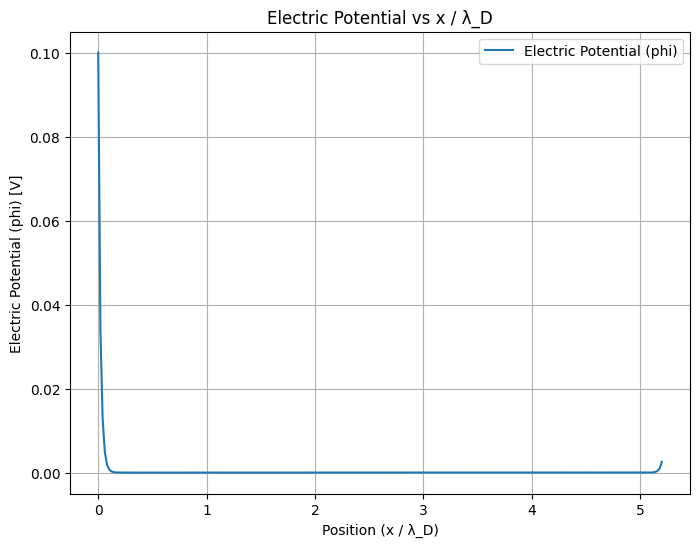

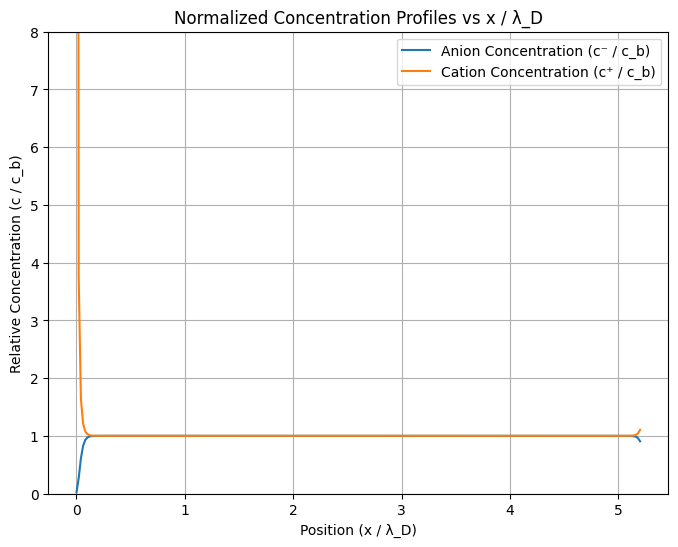

In [64]:
def main():
    # === 1. Set Parameters ===
    
    params = Params(
        T=298.15,
        epsilon_s=78.4,
        concentration_mM=100.0,
        phi_M=0.1,
        phi_pzc=0.0,
        N=2**8,
        L_min=0.0,
        L_max=5e-9
    )
    
    
    transformations = Transformations(params)

    # === 2. Spatial grid ===
    h = (params.L_max - params.L_min) / (params.N - 1)
    x = [params.L_min + i * h for i in range(params.N)]
    
    # === 3. Initial guess ===
    guesser = InitialGuess(params, x)
    phi0 = guesser.generate(mode="exponential")  # or 'cosine', 'analytical', etc.
   
    # === 4. Non-dimensionlize ===
    x = transformations.nondimensionalize_length(x)
    U_M = params.phi_M / transformations.compute_thermal_voltage()
    phi0 = [U_M * exp(-xi) for xi in x]

    # === 5. Solve nonlinear system ===
    solver = Solver(params, phi0, boundary_value=U_M, mode="dimensionless")
    solver.solve()
    phi = solver.get_phi()
    
    # === 6. Dimensionlize ===
    phi_dimensional = transformations.dimensionalize_potential(phi, phi_ref=params.phi_pzc)

    # === 7. Post-processing ===
    post = PostProcessing(params, phi_dimensional)
    c_minus, c_plus = post.calculate_concentration(params.c_b_mol)
    sigma = post.calculate_surface_charge_density()

    print(f"Surface charge density: {sigma:.4e} C/m²")

    # === 8. Plot results ===
    plotter = Plotting(params, phi_dimensional)
    plotter.plot_phi_vs_x()
    plotter.plot_concentration_vs_x(params.c_b_mol)


if __name__ == "__main__":
    main()


Iteration 0: Residual norm = 4.29e+09
Iteration 1: Residual norm = 1.58e+09
Iteration 2: Residual norm = 5.81e+08
Iteration 3: Residual norm = 2.14e+08
Iteration 4: Residual norm = 7.86e+07
Iteration 5: Residual norm = 2.89e+07
Iteration 6: Residual norm = 1.06e+07
Iteration 7: Residual norm = 3.91e+06
Iteration 8: Residual norm = 1.44e+06
Iteration 9: Residual norm = 5.30e+05
Iteration 10: Residual norm = 1.95e+05
Iteration 11: Residual norm = 7.17e+04
Iteration 12: Residual norm = 2.64e+04
Iteration 13: Residual norm = 9.70e+03
Iteration 14: Residual norm = 3.56e+03
Iteration 15: Residual norm = 1.31e+03
Iteration 16: Residual norm = 4.76e+02
Iteration 17: Residual norm = 1.70e+02
Iteration 18: Residual norm = 5.80e+01
Iteration 19: Residual norm = 1.72e+01
Iteration 20: Residual norm = 5.11e+00
Iteration 21: Residual norm = 1.39e+00
Iteration 22: Residual norm = 1.87e-01
Iteration 23: Residual norm = 3.97e-03
Iteration 24: Residual norm = 1.48e-06
Iteration 25: Residual norm = 1.76e

Iteration 1: Residual norm = 3.54e+05
Iteration 2: Residual norm = 1.30e+05
Iteration 3: Residual norm = 4.79e+04
Iteration 4: Residual norm = 1.76e+04
Iteration 5: Residual norm = 6.49e+03
Iteration 6: Residual norm = 2.38e+03
Iteration 7: Residual norm = 8.75e+02
Iteration 8: Residual norm = 3.19e+02
Iteration 9: Residual norm = 1.15e+02
Iteration 10: Residual norm = 3.95e+01
Iteration 11: Residual norm = 1.20e+01
Iteration 12: Residual norm = 4.01e+00
Iteration 13: Residual norm = 1.05e+00
Iteration 14: Residual norm = 1.30e-01
Iteration 15: Residual norm = 2.32e-03
Iteration 16: Residual norm = 5.63e-07
Iteration 17: Residual norm = 2.64e-14
Converged in 17 iterations with residual 2.64e-14
Iteration 0: Residual norm = 3.79e+05
Iteration 1: Residual norm = 1.39e+05
Iteration 2: Residual norm = 5.12e+04
Iteration 3: Residual norm = 1.88e+04
Iteration 4: Residual norm = 6.93e+03
Iteration 5: Residual norm = 2.55e+03
Iteration 6: Residual norm = 9.36e+02
Iteration 7: Residual norm = 3

Iteration 1: Residual norm = 4.44e+00
Iteration 2: Residual norm = 1.44e+00
Iteration 3: Residual norm = 3.09e-01
Iteration 4: Residual norm = 1.07e-02
Iteration 5: Residual norm = 1.19e-05
Iteration 6: Residual norm = 1.20e-11
Converged in 6 iterations with residual 1.20e-11
Iteration 0: Residual norm = 3.34e+01
Iteration 1: Residual norm = 1.17e+01
Iteration 2: Residual norm = 4.03e+00
Iteration 3: Residual norm = 1.25e+00
Iteration 4: Residual norm = 2.38e-01
Iteration 5: Residual norm = 6.36e-03
Iteration 6: Residual norm = 4.40e-06
Iteration 7: Residual norm = 1.53e-12
Converged in 7 iterations with residual 1.53e-12
Iteration 0: Residual norm = 8.49e+01
Iteration 1: Residual norm = 3.06e+01
Iteration 2: Residual norm = 1.05e+01
Iteration 3: Residual norm = 3.64e+00
Iteration 4: Residual norm = 1.09e+00
Iteration 5: Residual norm = 1.78e-01
Iteration 6: Residual norm = 3.61e-03
Iteration 7: Residual norm = 1.41e-06
Iteration 8: Residual norm = 1.61e-13
Converged in 8 iterations wi

Iteration 16: Residual norm = 7.22e-02
Iteration 17: Residual norm = 6.57e-04
Iteration 18: Residual norm = 4.16e-08
Iteration 19: Residual norm = 2.22e-16
Converged in 19 iterations with residual 2.22e-16
Iteration 0: Residual norm = 1.58e+07
Iteration 1: Residual norm = 5.83e+06
Iteration 2: Residual norm = 2.14e+06
Iteration 3: Residual norm = 7.89e+05
Iteration 4: Residual norm = 2.90e+05
Iteration 5: Residual norm = 1.07e+05
Iteration 6: Residual norm = 3.93e+04
Iteration 7: Residual norm = 1.44e+04
Iteration 8: Residual norm = 5.31e+03
Iteration 9: Residual norm = 1.95e+03
Iteration 10: Residual norm = 7.15e+02
Iteration 11: Residual norm = 2.60e+02
Iteration 12: Residual norm = 9.22e+01
Iteration 13: Residual norm = 3.06e+01
Iteration 14: Residual norm = 9.02e+00
Iteration 15: Residual norm = 2.91e+00
Iteration 16: Residual norm = 6.47e-01
Iteration 17: Residual norm = 5.20e-02
Iteration 18: Residual norm = 3.25e-04
Iteration 19: Residual norm = 9.86e-09
Converged in 19 iteratio

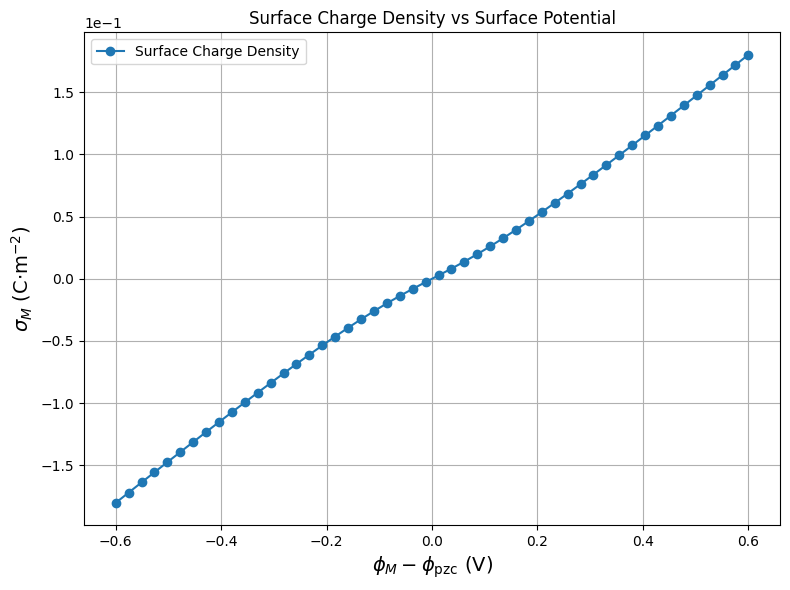

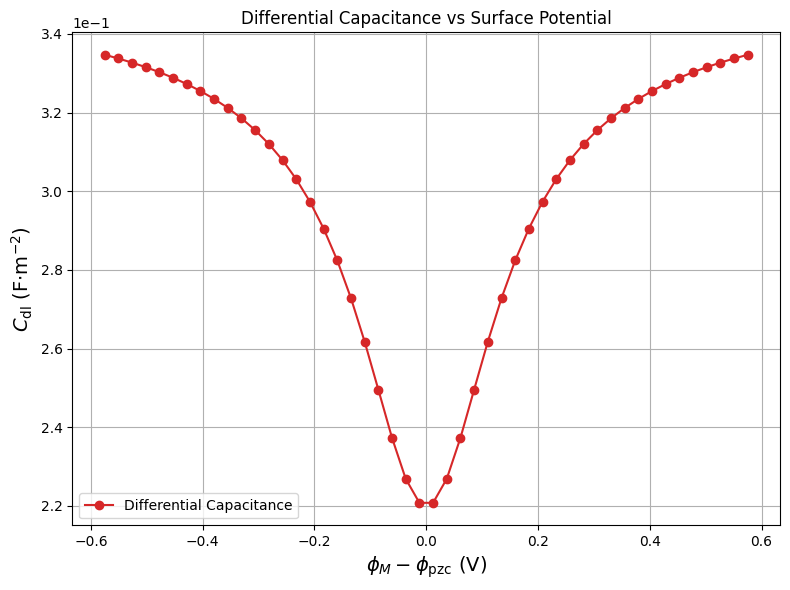

In [67]:
from math import exp
import matplotlib.pyplot as plt

def plot_surface_charge(phi_M_values, sigmas):
    sigmas_scaled = [s / 100 for s in sigmas]
    plt.figure(figsize=(8, 6))
    plt.plot(phi_M_values, sigmas_scaled, 'o-', label="Surface Charge Density", color="tab:blue")
    plt.xlabel(r"$\phi_M - \phi_{\mathrm{pzc}}$ (V)", fontsize=14)
    plt.ylabel(r"$\sigma_M$ (C$\cdot$m$^{-2}$)", fontsize=14)
    plt.title("Surface Charge Density vs Surface Potential")
    plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_capacitance(phi_mid, capacitances):
    capacitances_scaled = [c / 100 for c in capacitances]

    plt.figure(figsize=(8, 6))
    plt.plot(phi_mid, capacitances_scaled, 'o-', label="Differential Capacitance", color="tab:red")
    plt.xlabel(r"$\phi_M - \phi_{\mathrm{pzc}}$ (V)", fontsize=14)
    plt.ylabel(r"$C_{\mathrm{dl}}$ (F$\cdot$m$^{-2}$)", fontsize=14)
    plt.title("Differential Capacitance vs Surface Potential")
    plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()




def run_sweep_over_phi_M(phi_M_values):
    sigmas = []

    for phi_M in phi_M_values:
        params = Params(
            T=298.15,
            epsilon_s=78.4,
            concentration_mM=100.0,
            phi_M=phi_M,
            phi_pzc=0.0,
            N=2**8,
            L_min=0.0,
            L_max=5e-9
        )

        transformations = Transformations(params)
        h = (params.L_max - params.L_min) / (params.N - 1)
        x = [params.L_min + i * h for i in range(params.N)]
        x = transformations.nondimensionalize_length(x)
        U_M = params.phi_M / transformations.compute_thermal_voltage()
        phi0 = [U_M * exp(-xi) for xi in x]

        solver = Solver(params, phi0, boundary_value=U_M, mode="dimensionless")
        solver.solve()
        phi = solver.get_phi()
        phi_dim = transformations.dimensionalize_potential(phi, phi_ref=params.phi_pzc)

        post = PostProcessing(params, phi_dim)
        sigma = post.calculate_surface_charge_density()
        sigmas.append(sigma)

    # Compute differential capacitance using central difference
    capacitances = []
    phi_mid = []

    for i in range(1, len(sigmas) - 1):
        dphi = phi_M_values[i + 1] - phi_M_values[i - 1]
        dsigma = sigmas[i + 1] - sigmas[i - 1]
        C_dl = dsigma / dphi
        capacitances.append(C_dl)
        phi_mid.append(phi_M_values[i])

    plot_surface_charge(phi_M_values, sigmas)
    plot_capacitance(phi_mid, capacitances)


def main():
    params = Params(
        T=298.15,
        epsilon_s=78.4,
        concentration_mM=100.0,
        phi_M=1.0,
        phi_pzc=0.0,
        N=2**8,
        L_min=0.0,
        L_max=5e-9
    )

    transformations = Transformations(params)

    h = (params.L_max - params.L_min) / (params.N - 1)
    x = [params.L_min + i * h for i in range(params.N)]

    guesser = InitialGuess(params, x)
    phi0 = guesser.generate(mode="exponential")

    x = transformations.nondimensionalize_length(x)
    U_M = params.phi_M / transformations.compute_thermal_voltage()
    phi0 = [U_M * exp(-xi) for xi in x]

    solver = Solver(params, phi0, boundary_value=U_M, mode="dimensionless")
    solver.solve()
    phi = solver.get_phi()

    phi_dimensional = transformations.dimensionalize_potential(phi, phi_ref=params.phi_pzc)

    post = PostProcessing(params, phi_dimensional)
    c_minus, c_plus = post.calculate_concentration(params.c_b_mol)
    sigma = post.calculate_surface_charge_density()

    print(f"Surface charge density: {sigma:.4e} C/m²")

    plotter = Plotting(params, phi_dimensional)
    plotter.plot_phi_vs_x()
    plotter.plot_concentration_vs_x(params.c_b_mol)


if __name__ == "__main__":
    do_sweep = True  # Set to False to run main(), or True to run the sweep

    if do_sweep:
        M = 50
        phi_M_values = [-0.6 + 1.2 * i / (M - 1) for i in range(M)]  
        run_sweep_over_phi_M(phi_M_values)
    else:
        main()
